In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [42]:
#find last date in data
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


<IPython.core.display.Javascript object>


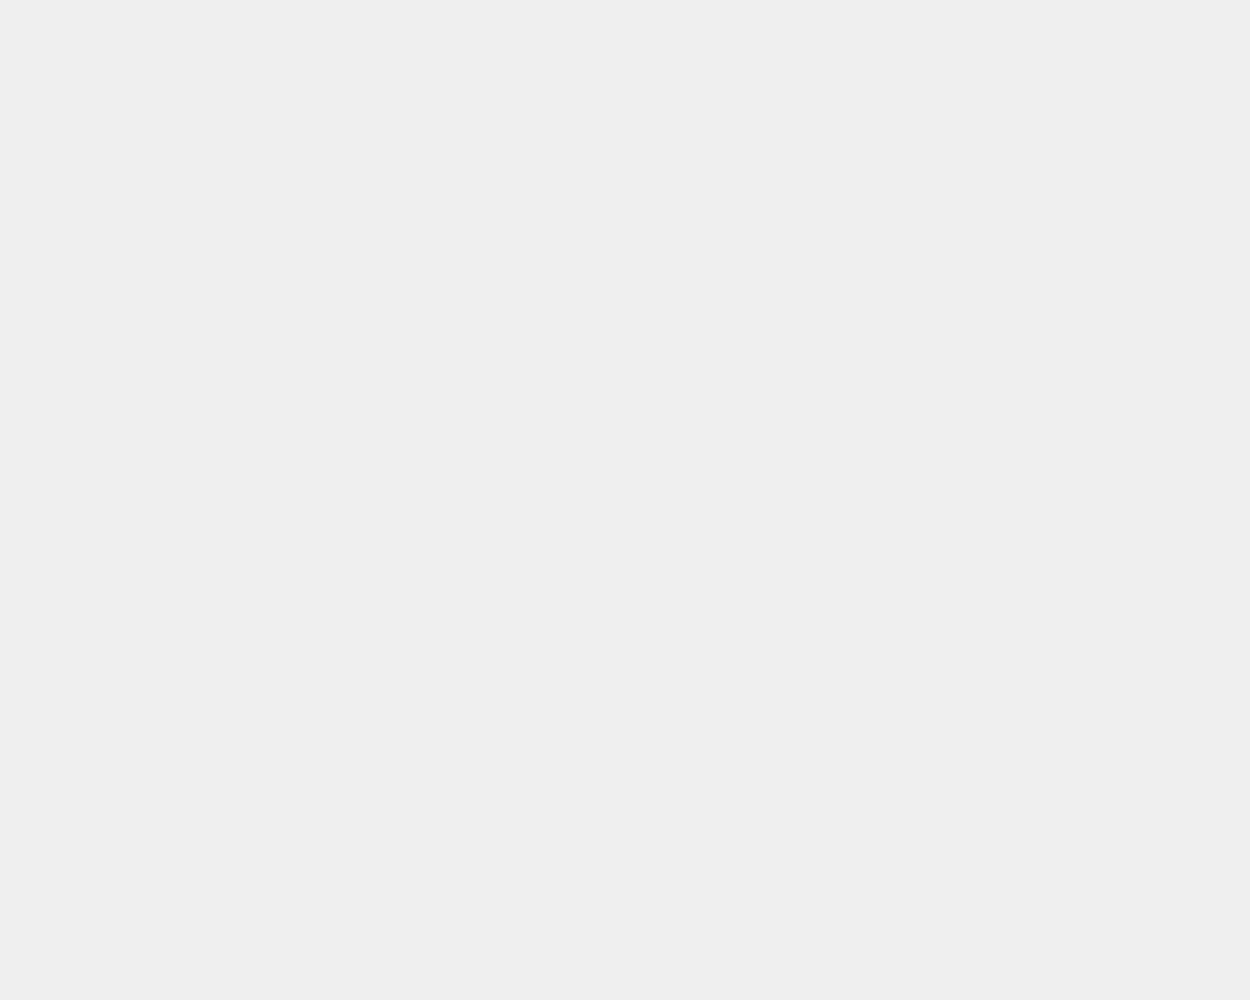

<IPython.core.display.Javascript object>


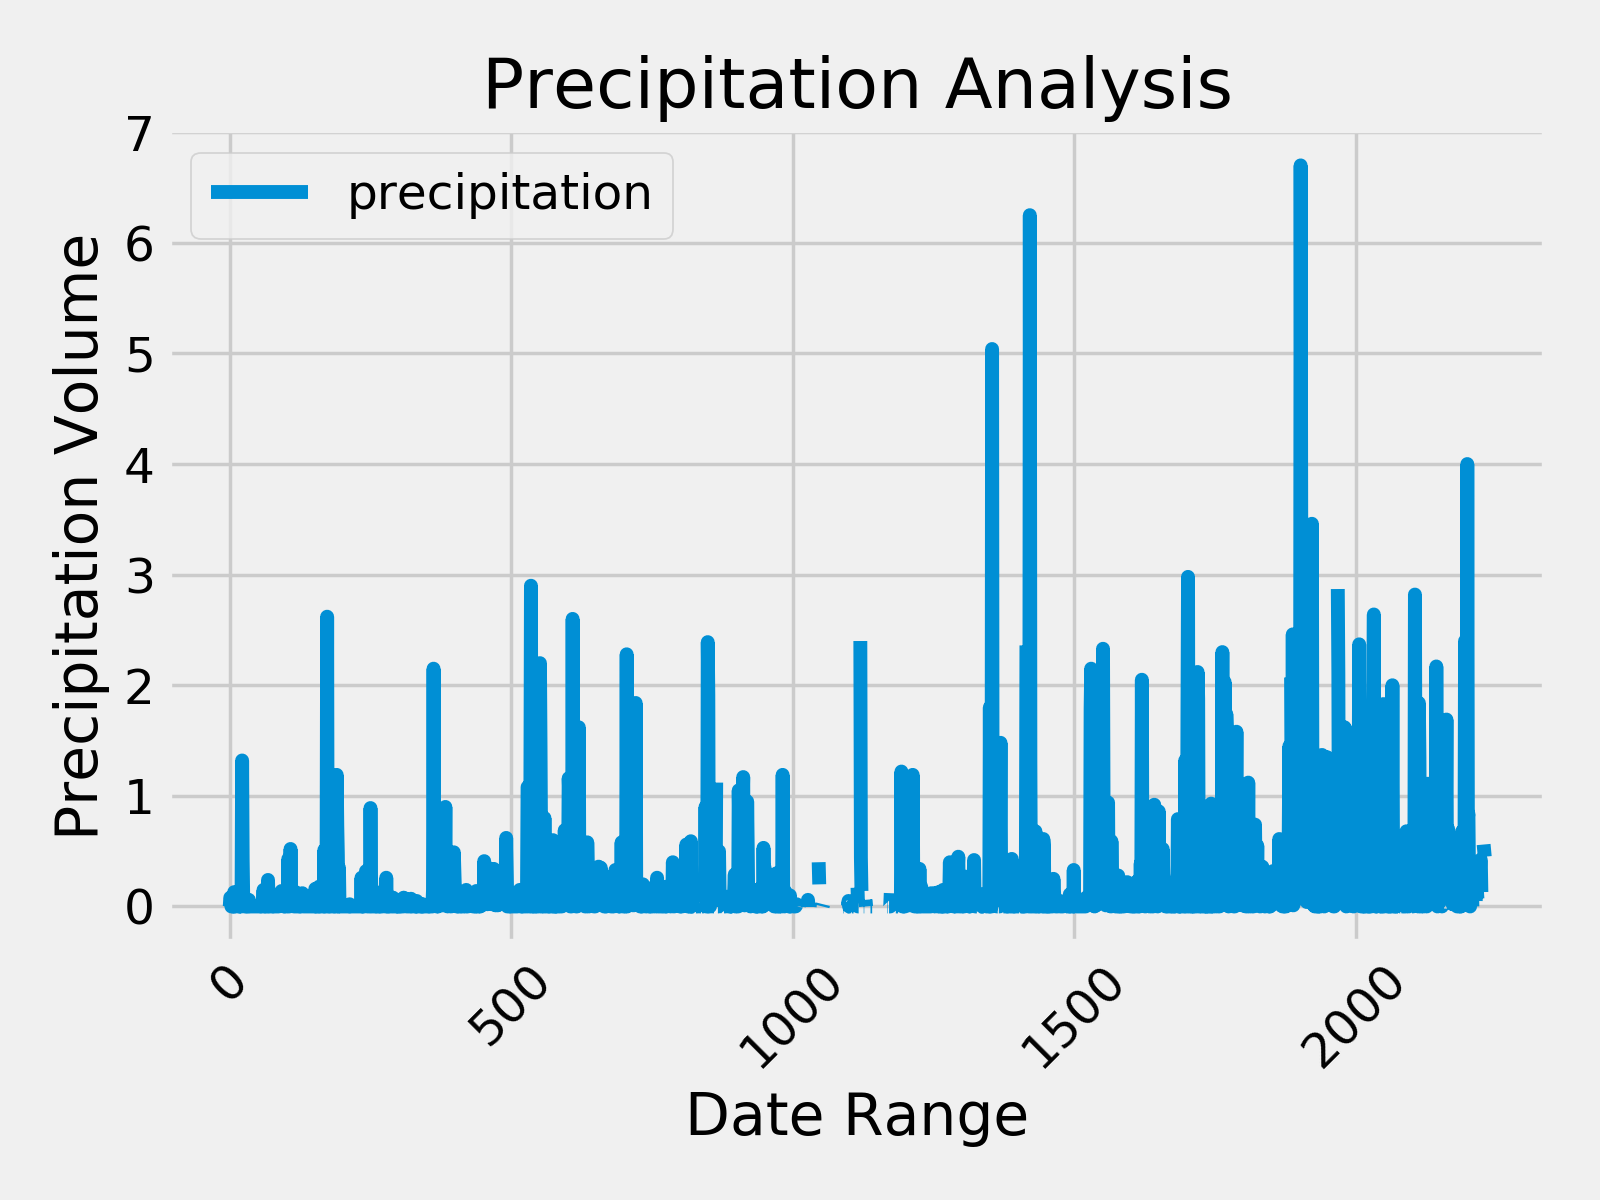

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from today
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
df = pd.DataFrame(results, columns=['date', 'precipitation'])


# Sort the dataframe by date
df.drop(columns='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data x_compat = true
# Rotate the xticks for the dates
fig1= plt.figure(figsize=(5,4))
df.plot(x_compat=True)
plt.xlabel("Date Range")
plt.ylabel("Precipitation Volume")
plt.title("Precipitation Analysis")
plt.xticks(rotation='45')
plt.tight_layout()
plt.show()


In [14]:
# Perform a query to retrieve the data and precipitation scores
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![precipitation](Images/precipitation.png)

In [28]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


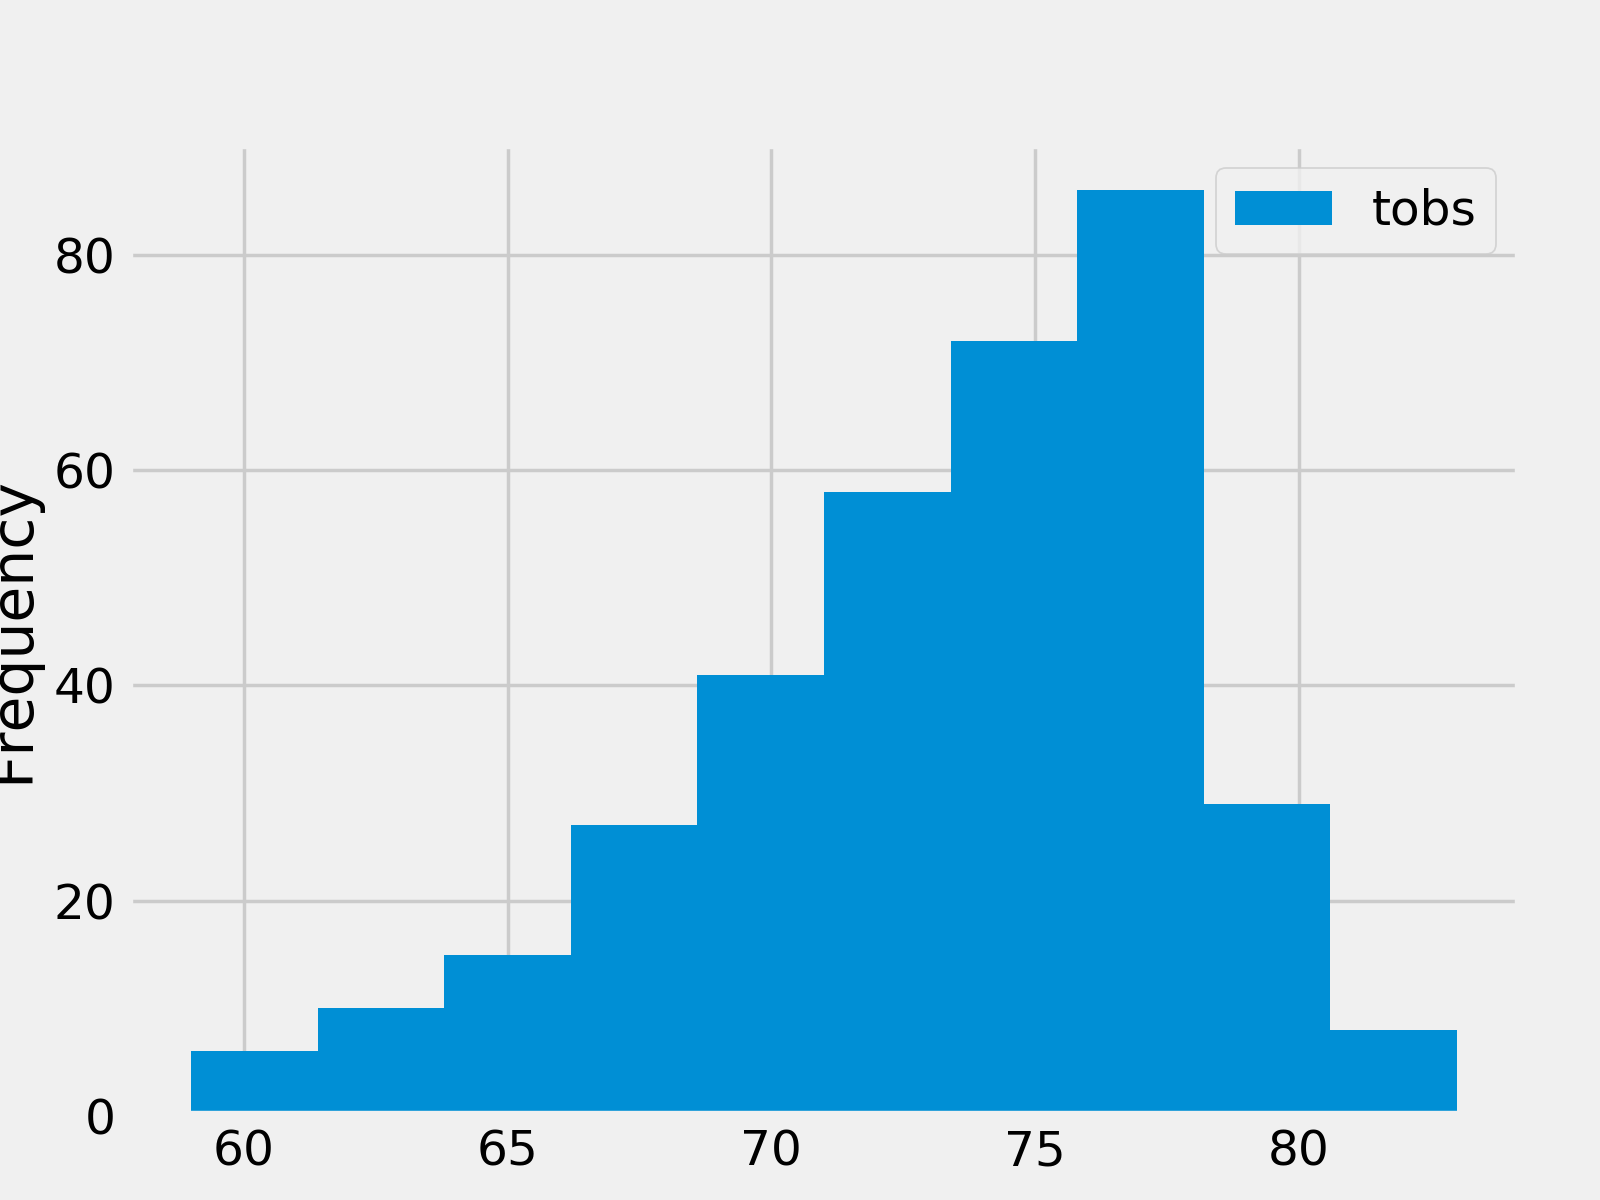

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results2 = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')\
.filter(Measurement.date >= one_year_ago).all()

df2 = pd.DataFrame(results2, columns=['tobs'])
df2.plot.hist()
plt.show()

In [31]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
.filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

<IPython.core.display.Javascript object>


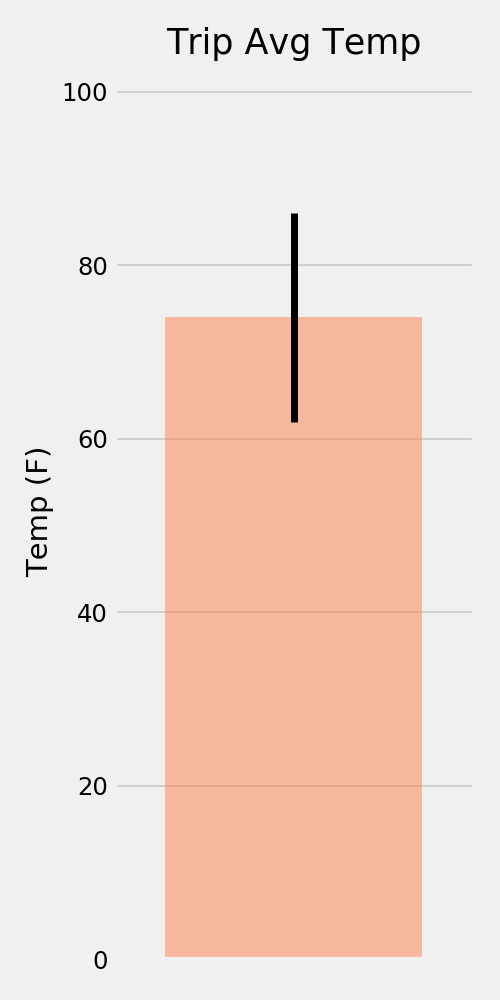

[(53.0, 72.97378133169306, 86.0)]


<IPython.core.display.Javascript object>


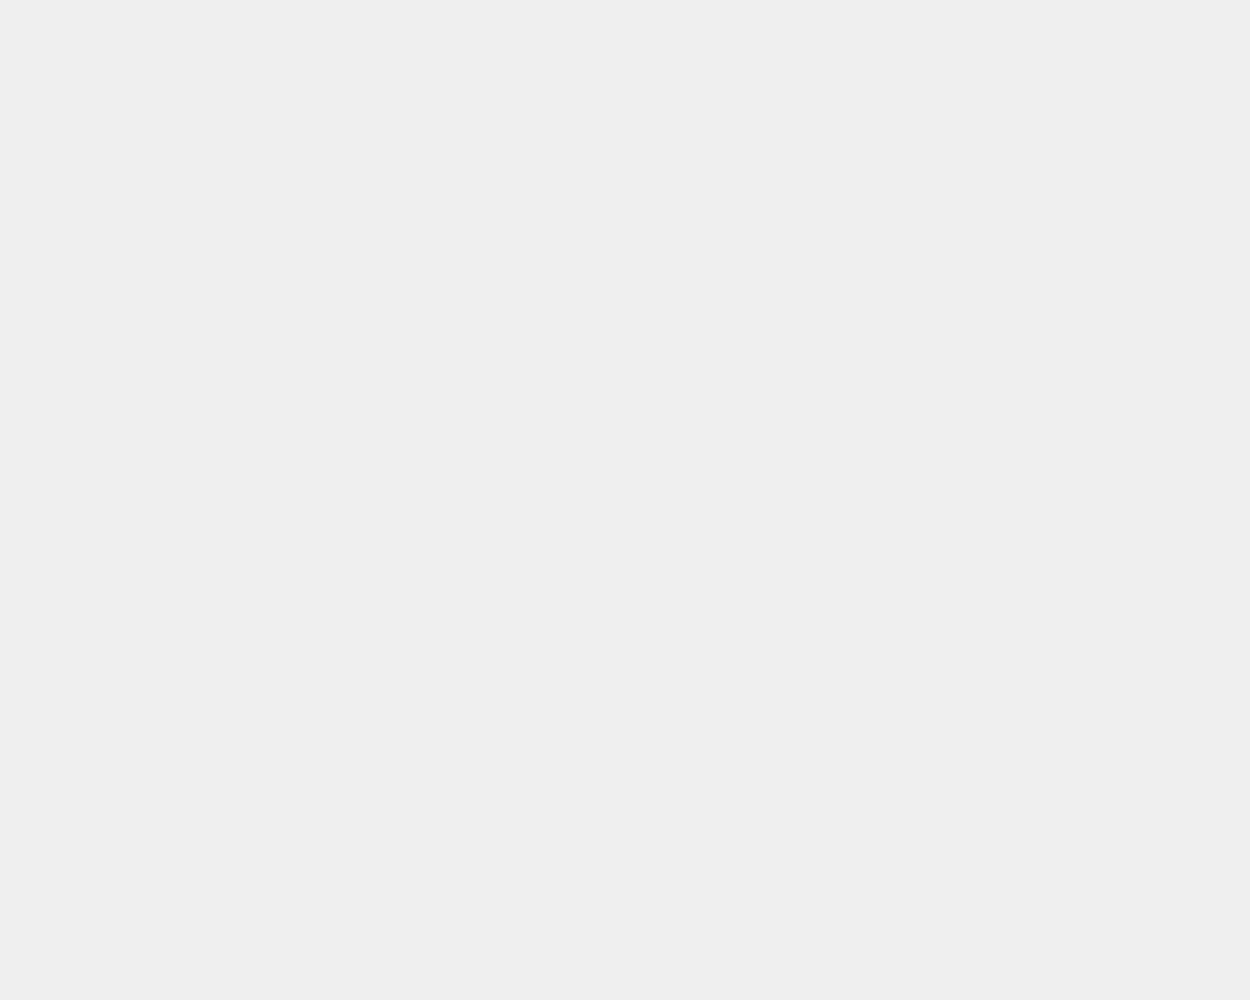

<IPython.core.display.Javascript object>


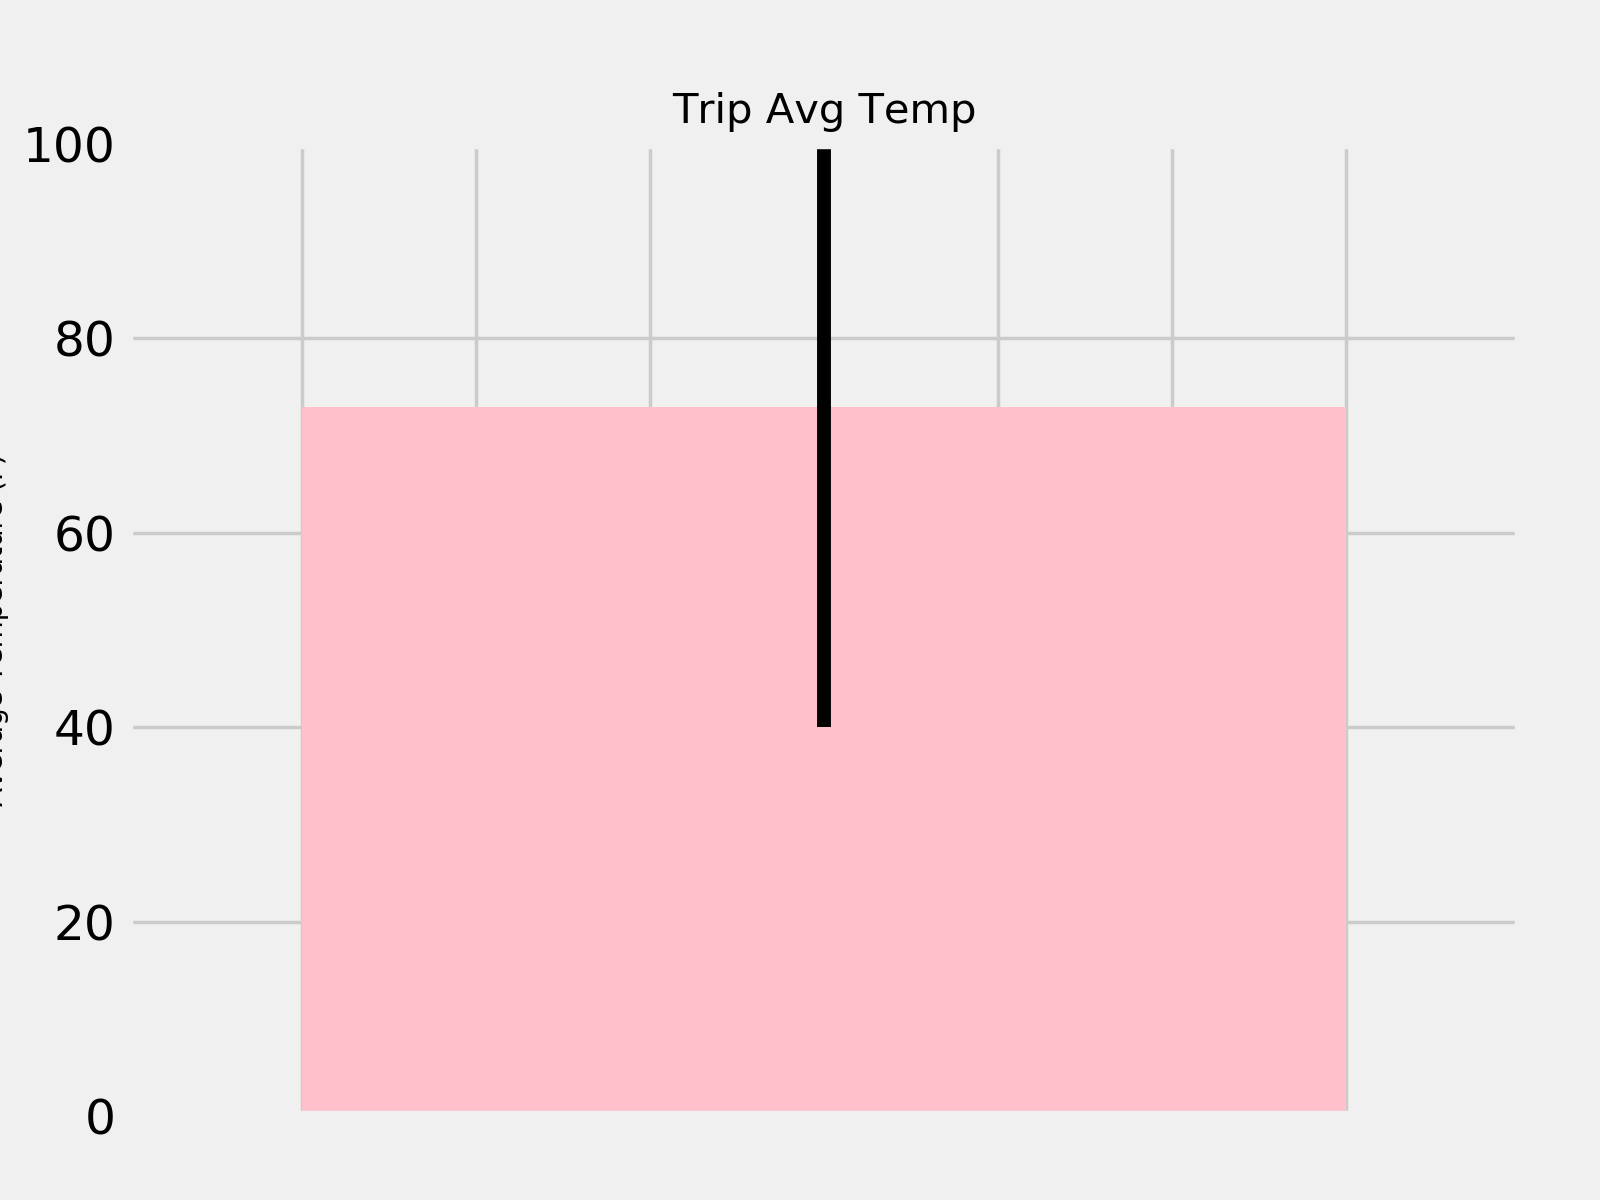

C:\Users\knkin\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y  #'2012-02-28', '2012-03-05'
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your 'trip' using the 'previous year's' data for those same dates.
arrival_date = dt.date(2012, 2 , 28)
departure_date = dt.date(2017, 3, 5)
one_year_ago = dt.timedelta(days=365)
tavg_year_ago = (calc_temps((arrival_date-one_year_ago), (departure_date-one_year_ago)))
print(tavg_year_ago)

# Define standard error (max minus min temps)
yerr_val = tavg_year_ago[0][2] - tavg_year_ago[0][0]

# Y value is the average temperature for the trip's date range; X is zero since we only need one bar
y = [tavg_year_ago[0][1]]
x = 0

fig3 = plt.figure(figsize=(5,4))
fig, ax = plt.subplots()

# Add  labels, title and axes ticks
ax.set_ylabel("Average Temperature (F)", fontsize=8)
ax.set_title("Trip Avg Temp", fontsize=12)

# Set the limits of the x and y axes, no tick params
ax.bar(x, y, width=1.5, color="pink", yerr=yerr_val)
ax.set_xlim(-1, 1)
ax.set_ylim(0, 100)
ax.set_xbound(lower=-1, upper=1)
ax.tick_params(axis='x', which='both', bottom='false', top='false', labelbottom='false') 
plt.show()

<IPython.core.display.Javascript object>


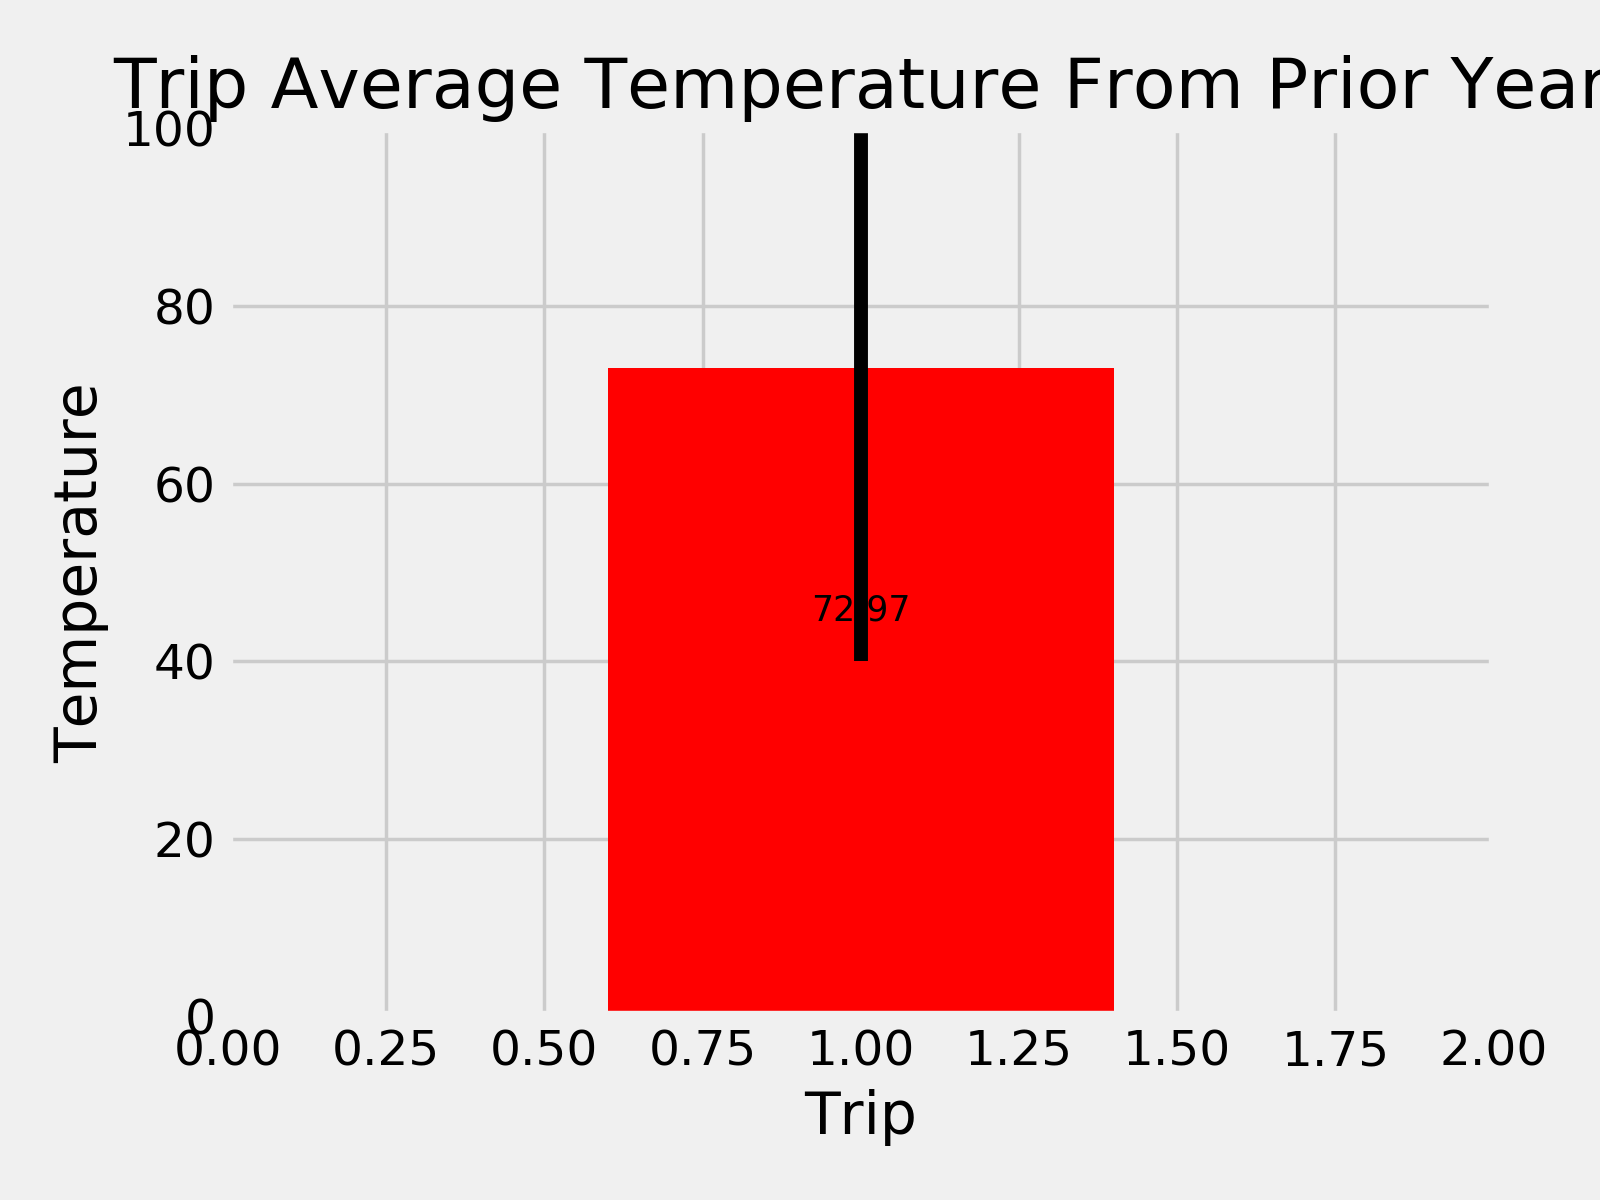

In [40]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = tavg_year_ago[0][2]-tavg_year_ago[0][0]
avgtemp = tavg_year_ago[0][1]
min_temp = tavg_year_ago[0][0]
max_temp = tavg_year_ago[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()

## Step 2 - Climate App

Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

* Use FLASK to create your routes.

### Routes

* `/api/v1.0/precipitation`

  * Query for the dates and temperature observations from the last year.

  * Convert the query results to a Dictionary using `date` as the key and `prcp` as the value.

  * Return the JSON representation of your dictionary.

* `/api/v1.0/stations`

  * Return a JSON list of stations from the dataset.

* `/api/v1.0/tobs`

  * Return a JSON list of Temperature Observations (tobs) for the previous year.

* `/api/v1.0/<start>` and `/api/v1.0/<start>/<end>`

  * Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

  * When given the start only, calculate `TMIN`, `TAVG`, and `TMAX` for all dates greater than and equal to the start date.

  * When given the start and the end date, calculate the `TMIN`, `TAVG`, and `TMAX` for dates between the start and end date inclusive.

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


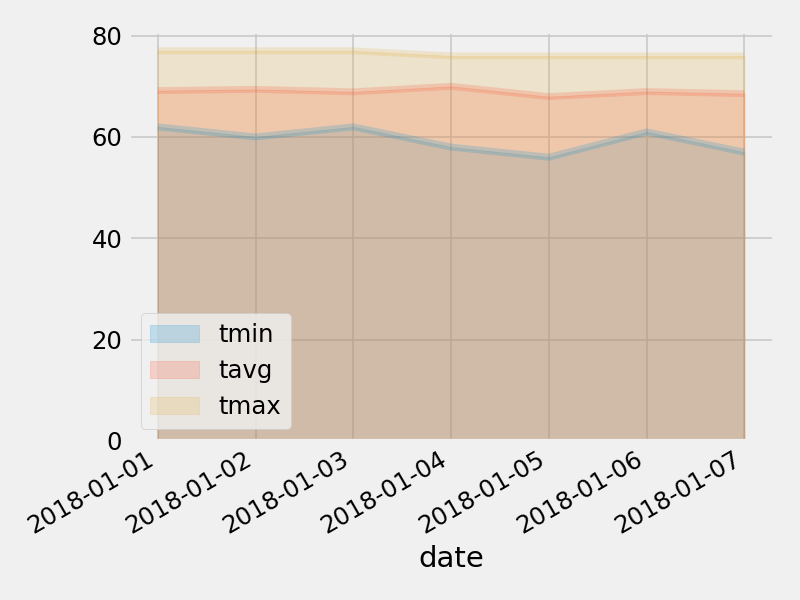

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
